In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

import re
import emoji

### Load Data

The data we load in is the output of the `extract_tweet_data.py` script.

The expected dataframe contains the tweet text and the extracted emojis. The columns are:
- **tweet_text**: The tokenized text of the tweet
- **emojis**: the emojis extracted from the tweet
- **emojis_unq**: sorted list of unique emojis in the tweet. Used for looking up tweets based on emojis
- **n_tokens, n_emojis, n_emojis_unq**: counts for the other columns

I keep only the tweets that have emojis in them.

In [3]:
tweets_df = pd.read_csv('capstone/tokenized_tweets.csv', index_col=0)
print(f"Initial Number of Tweets: {tweets_df.shape[0]}")
print(f"Number of NaN Tweets: {tweets_df['tweet_text'].isna().sum()}")
#filter for tweets that have at least 1 emoji
#This will also remove tweets that have NaN tweet_text
tweets_w_emojis_df = tweets_df[tweets_df['n_emojis']!=0]
print(f"Number of Tweets with Emojis: {tweets_w_emojis_df.shape[0]}")

Initial Number of Tweets: 683362
Number of NaN Tweets: 38419
Number of Tweets with Emojis: 142733


## How Long Should A Tweet Be?

Let's take a look at the distribution of tweet lengths. From the plot below we can see that we can capture 95% of the tweets by limiting the length to 23 tokens. 

I will limit the length of the tweets to be no more than 30 tokens. This choice helps reduce the size of the model. 

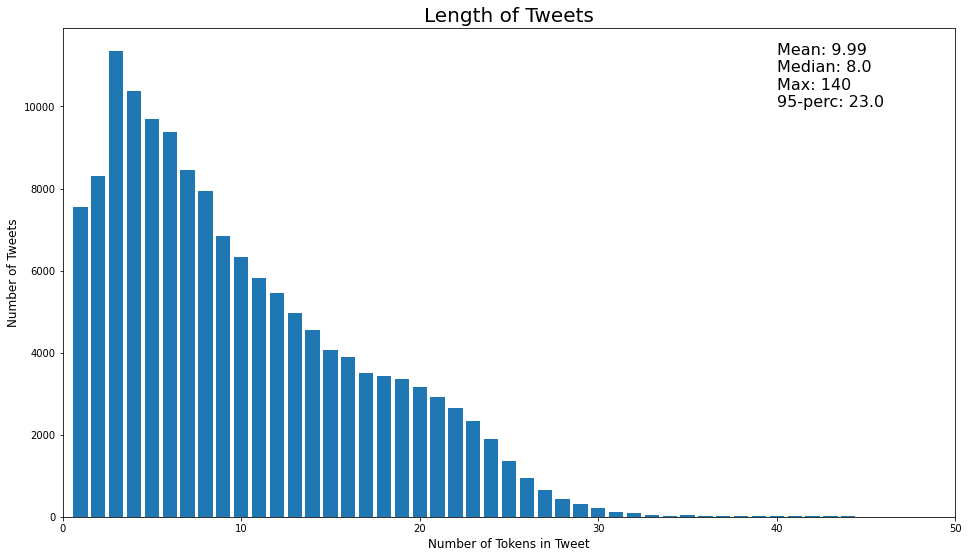

In [4]:
plot_df = tweets_w_emojis_df
avg_val = plot_df['n_tokens'].mean()
median_val = plot_df['n_tokens'].median()
max_val = plot_df['n_tokens'].max()
perc_val = np.percentile(plot_df['n_tokens'], 95)
hist_data = plot_df['n_tokens'].value_counts()
plt.figure(figsize=(16,9))
plt.bar(hist_data.index, hist_data)
plt.title('Length of Tweets', fontsize=20)
plt.xlabel('Number of Tokens in Tweet', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlim(0, 50)
plt.text(40, 10000, f'Mean: {avg_val:1.2f}\nMedian: {median_val}\nMax: {max_val}\n95-perc: {perc_val}', fontsize=16)
plt.show()

In [6]:
token_limit = 30
n_tweets_to_drop = tweets_w_emojis_df[tweets_w_emojis_df['n_tokens'] > token_limit].shape[0]
print(f'Number of tweets that are longer than {token_limit}: {n_tweets_to_drop}')
# This mask will be used to filter the tweets. It is combined with another mask later
token_limit_mask = tweets_w_emojis_df['n_tokens'] <= 30

Number of tweets that are longer than 30: 528


## Exploring How Emojis are Used

Similarly, let's look at the distribution of number of emojis used in tweets. From the plot below we can capture 95% of the tweets by setting an emoji limit of 5. 

Why would we limit the number of emojis? There are a number of tweets are are composed entirely of emojis, and sometimes is the same emoji. These tweets are not representative of the tweets we would like to genearte.
I'm using the emoji limit as proxy to removing repeated tokens in tweets. Alternatively, I could look at the list of unique emojis in the tweet thus eliminating duplicates.

TODO: Instead of simply setting a token limit, there's gotta be a way to remove repeated patterns. That is, not just repeated tokens, but repeat groups of tokens. 

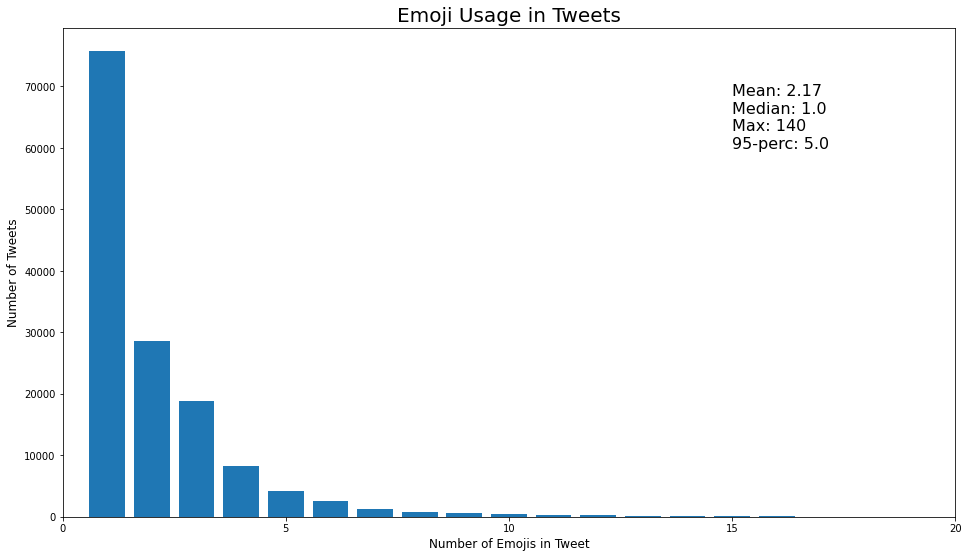

In [8]:
plot_df = tweets_w_emojis_df
avg_val = plot_df['n_emojis'].mean()
median_val = plot_df['n_emojis'].median()
max_val = plot_df['n_emojis'].max()
perc_val = np.percentile(plot_df['n_emojis'], 95)
hist_data = plot_df['n_emojis'].value_counts()

plt.figure(figsize=(16,9))
plt.bar(hist_data.index, hist_data)
plt.title('Emoji Usage in Tweets', fontsize=20)
plt.xlabel('Number of Emojis in Tweet', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 5.0))
plt.text(15, 60000, f'Mean: {avg_val:1.2f}\nMedian: {median_val}\nMax: {max_val}\n95-perc: {perc_val}', fontsize=16)
plt.show()

Additionally, let's look at how the distribution of unique emojis in tweets.

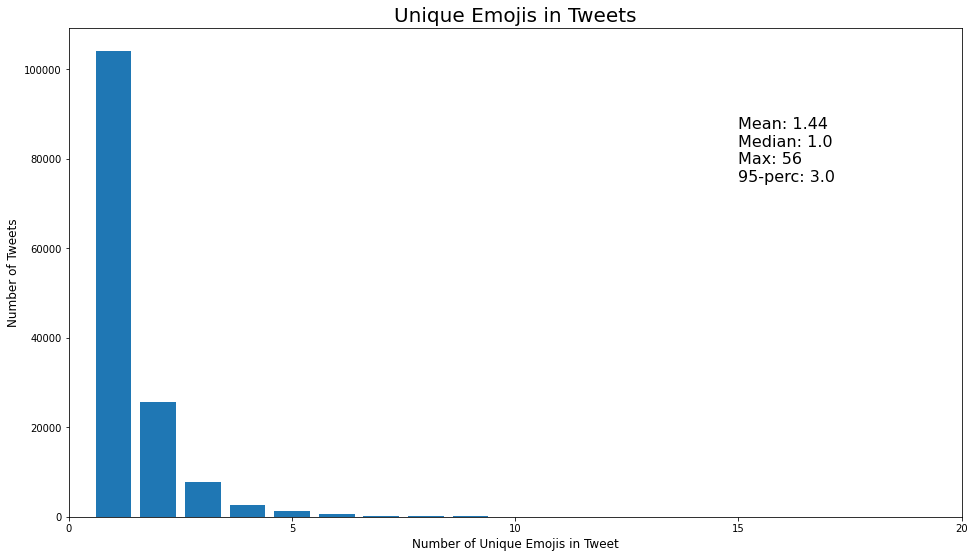

In [10]:
plot_df = tweets_w_emojis_df
avg_val = plot_df['n_emojis_unq'].mean()
median_val = plot_df['n_emojis_unq'].median()
max_val = plot_df['n_emojis_unq'].max()
perc_val = np.percentile(plot_df['n_emojis_unq'], 95)
hist_data = plot_df['n_emojis_unq'].value_counts()

plt.figure(figsize=(16,9))
plt.bar(hist_data.index, hist_data)
plt.title('Unique Emojis in Tweets', fontsize=20)
plt.xlabel('Number of Unique Emojis in Tweet', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 5.0))
plt.text(15, 75000, f'Mean: {avg_val:1.2f}\nMedian: {median_val}\nMax: {max_val}\n95-perc: {perc_val}', fontsize=16)
plt.show()

In [12]:
emoji_limit = 10
n_tweets_to_drop = tweets_w_emojis_df[tweets_w_emojis_df['n_emojis'] > emoji_limit].shape[0]
print(f'Number of tweets with more than {emoji_limit} emojis: {n_tweets_to_drop}')
emoji_limit_mask = tweets_w_emojis_df['n_emojis'] <= emoji_limit

Number of tweets with more than 10 emojis: 1376


## Repeated Emojis in Tweets

Let's look at how many tweets have repeated emojis

In [24]:
n_tweets_rep_emoji = (red_tweets_w_emojis_df['n_emojis'] != red_tweets_w_emojis_df['n_emojis_unq']).sum()
print(f'Number of tweets with repeated emojis: {n_tweets_rep_emoji}')

Number of tweets with repeated emojis: 28208


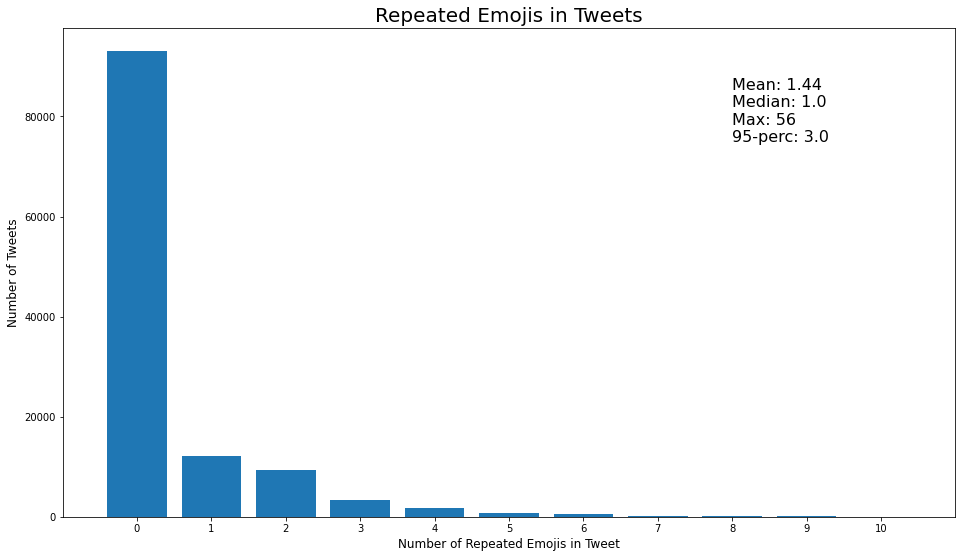

In [34]:
hist_data = (red_tweets_w_emojis_df['n_emojis'] - red_tweets_w_emojis_df['n_emojis_unq']).value_counts()

plt.figure(figsize=(16,9))
plt.bar(hist_data.index, hist_data)
plt.title('Repeated Emojis in Tweets', fontsize=20)
plt.xlabel('Number of Repeated Emojis in Tweet', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlim(-1, 11)
plt.text(8, 75000, f'Mean: {avg_val:1.2f}\nMedian: {median_val}\nMax: {max_val}\n95-perc: {perc_val}', fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.show()

## No words, just emojis

I will remove tweets that contain only emojis. They are not representative of the type of tweet I'm hoping to generate. The goal is to use words to fill in or glue the emojis togethers.

In [13]:
n_tweets_to_drop = (tweets_w_emojis_df['n_tokens'] == tweets_w_emojis_df['n_emojis']).sum()
print(f'Number of tweets that are only emojis: {n_tweets_to_drop}')
word_emoji_mask = tweets_w_emojis_df['n_tokens'] != tweets_w_emojis_df['n_emojis']

Number of tweets that are only emojis: 20179


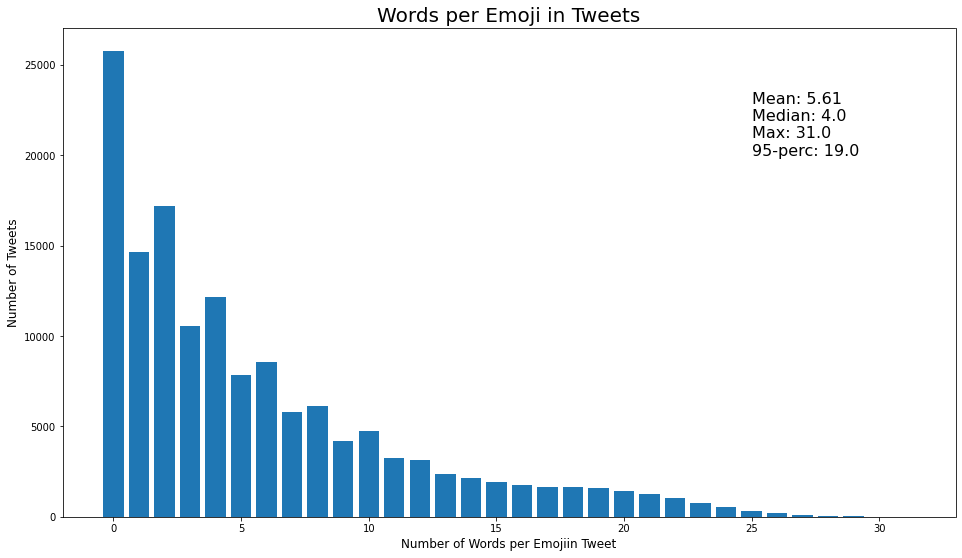

In [41]:
words_per_emoji = ((tweets_w_emojis_df['n_tokens'] - tweets_w_emojis_df['n_emojis'])/tweets_w_emojis_df['n_emojis']).round()

plot_df = words_per_emoji
avg_val = words_per_emoji.mean()
median_val = words_per_emoji.median()
max_val = words_per_emoji.max()
perc_val = np.percentile(words_per_emoji, 95)
hist_data = words_per_emoji.value_counts()

plt.figure(figsize=(16,9))
plt.bar(hist_data.index, hist_data)
plt.title('Words per Emoji in Tweets', fontsize=20)
plt.xlabel('Number of Words per Emojiin Tweet', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
#plt.xlim(0, 20)
#plt.xticks(np.arange(0, 21, 5.0))
plt.text(25, 20000, f'Mean: {avg_val:1.2f}\nMedian: {median_val}\nMax: {max_val}\n95-perc: {perc_val}', fontsize=16)
plt.show()

## Filtering the Tweets

I filter the tweets by combining the masks. I've kept only the tweets that have less than or equal to 30 tokens (words + emojis), and less than or equal to 10 emojis.

In [14]:
# create a copy to avoid issues later when adding a column to this slice of the data
# red prefix denotes a reduced set of emojis
red_tweets_w_emojis_df = tweets_w_emojis_df[emoji_limit_mask & token_limit_mask & word_emoji_mask].copy()
print(f'Resultant number of tweets: {red_tweets_w_emojis_df.shape[0]}')

Resultant number of tweets: 121326


In [15]:
red_tweets_w_emojis_df

,tweet_text,emojis,emojis_unq,n_tokens,n_emojis,n_emojis_unq
1,Thanks so much pretty Means a lot 🥺 🥺 💖 💖 Lmao...,🥺 🥺 💖 💖 😳 💀,💀 💖 😳 🥺,21,6,4
10,love you more 😍 😍 🥵 🥵 🥵,😍 😍 🥵 🥵 🥵,😍 🥵,8,5,2
14,came home to gifts for no reason 🥺 🥺 my heart,🥺 🥺,🥺,11,2,1
20,الحمدللهههه 💛 💛 💛 💛,💛 💛 💛 💛,💛,5,4,1
25,Especially when you lose in that 8 ball cous 😂 😂,😂 😂,😂,11,2,1
...,...,...,...,...,...,...
683342,I thought sac meant bag in French so I had no ...,🤣,🤣,13,1,1
683347,Re tla bona 🤣 🤣 🤣,🤣 🤣 🤣,🤣,6,3,1
683353,Loveeeee 🥰,🥰,🥰,2,1,1
683354,Can imagine its Rocking to BLUE MOON Nigel 😎 🍺 🍹,😎 🍺 🍹,🍹 🍺 😎,11,3,3


## Splitting the Data for Training and Testing

I set aside 30% of the data for testing.

TODO: Explore stratifying the data along number of tokens or emojis in tweet.

In [17]:
# data is shuffled by default
train_tweets_df, test_tweets_df = train_test_split(red_tweets_w_emojis_df, test_size=0.30, random_state=23)
print(f'Training Set Shape: {train_tweets_df.shape[0]}')
print(f'Testing Set Shape: {test_tweets_df.shape[0]}')

Training Set Shape: 84928
Testing Set Shape: 36398


## Save the DataFrame for Use in Google Colab
Finally I save the dataframe so I can use it with Google Colab. 

In [18]:
train_tweets_df.to_csv("capstone/training_tweets.csv")
test_tweets_df.to_csv("capstone/testing_tweets.csv")